In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import random
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
################# Parameters #####################
path = "myData" # folder with all the class folders
labelFile = 'labels.csv' # file with all names of classes
batch_size_val=64  # how many to process together
epochs_val=20
imageDimesions = (30,30,3)
testRatio = 0.2    # if 1000 images split will 200 for testing
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation
###################################################

In [3]:
############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        curImg = cv2.resize(curImg, (30, 30))
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [4]:
print(imageDimesions[0])
print(images.shape)

30
(34799, 30, 30, 3)


In [5]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 
# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [6]:
#TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(22271, 30, 30, 3) (22271,)
Validation(5568, 30, 30, 3) (5568,)
Test(6960, 30, 30, 3) (6960,)


In [8]:
# READ CSV FILE
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


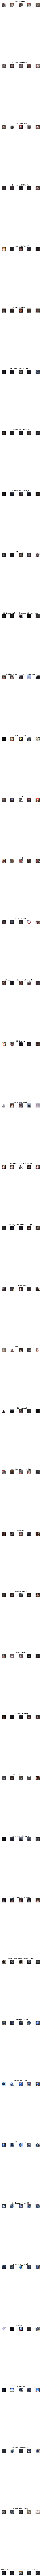

In [9]:
# DISPLAY SOME SAMPLES IMAGES OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

[118, 1265, 1277, 820, 1133, 1082, 230, 863, 784, 838, 1174, 757, 1202, 1184, 446, 352, 226, 638, 700, 109, 197, 174, 202, 292, 146, 870, 349, 139, 320, 150, 254, 420, 129, 385, 225, 695, 192, 116, 1192, 162, 192, 124, 148]


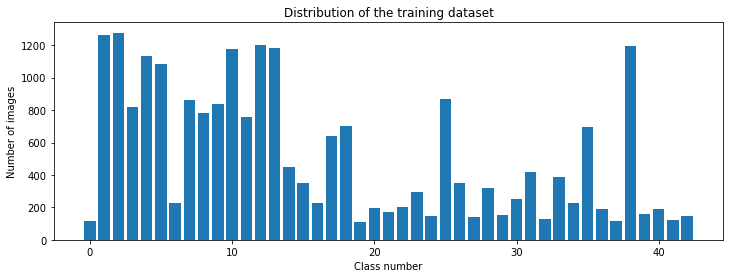

In [10]:
# DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [12]:
# PREPROCESSING THE IMAGES

def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img =cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

In [13]:
X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

In [14]:
# ADD A DEPTH OF 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [15]:
############################### AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

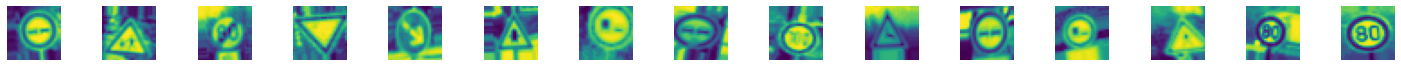

In [16]:
# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [17]:
def myModel():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
# TRAIN
model = myModel()
print(model.summary())

history = model.fit(X_train, y_train, batch_size=batch_size_val, epochs=epochs_val, validation_data=(X_validation,y_validation))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

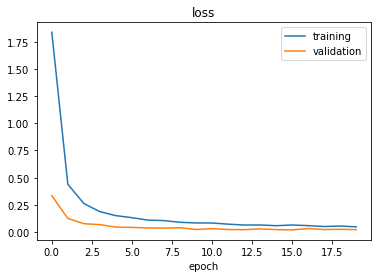

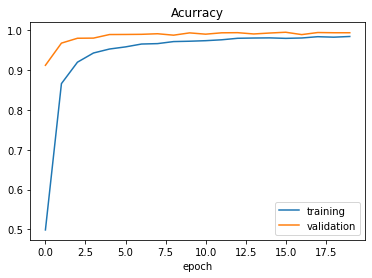

Test Score: 0.02115768752992153
Test Accuracy: 0.9933907985687256


In [19]:
############################### PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])
 

In [20]:
#model.save("CNN_model_4.h5")

In [21]:
model.save("CNN_model_3.h5")

In [24]:
#testing accuracy on test dataset
from sklearn.metrics import accuracy_score

y_test = pd.read_csv('Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

for img in imgs:
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))

X_test=np.array(data)

X_test=np.array(list(map(preprocessing,X_test)))

predict_x=model.predict(X_test) 

pred=np.argmax(predict_x,axis=1)

print(accuracy_score(labels, pred))

395/395 [==============================] - 11s 28ms/step
0.9577197149643706
